In [1]:
import ffrd_data_utils as fdu
import xarray as xr
import json

In [2]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42799,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:46111,Total threads: 3
Dashboard: http://127.0.0.1:33881/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:41857,


In [3]:
TERRAIN = "./data/terrain/Terrain_Addison_M03.cog.tif"
WSEL_TIFS = "./data/wsel_grids/*.tif"
# WSEL_TIFS = "./data/wsel_grids/*.cog.tif"
WSEL_ZARR = "./data/wsel.zarr"
WSEL_RECHUNKED_ZARR = "./data/wsel_rechunked.zarr"
DEPTH_ZARR = "./data/depth.zarr"
WEIGHTS = './data/Addison_M03_H04_Weights.json'
SAMPLE = True
RETURN_PERIODS = [10, 50, 100, 500]

In [4]:
# consolidate wsel tifs and terrain into a single zarr dataset
fdu.tifs_to_zarr(WSEL_TIFS, TERRAIN, WSEL_ZARR, sample=SAMPLE)

0 ./data/wsel_grids/WSE_Addison_M03_H04_E4001.tif
1 ./data/wsel_grids/WSE_Addison_M03_H04_E4002.tif
2 ./data/wsel_grids/WSE_Addison_M03_H04_E4003.tif
3 ./data/wsel_grids/WSE_Addison_M03_H04_E4004.tif
4 ./data/wsel_grids/WSE_Addison_M03_H04_E4005.tif
5 ./data/wsel_grids/WSE_Addison_M03_H04_E4006.tif
6 ./data/wsel_grids/WSE_Addison_M03_H04_E4007.tif
7 ./data/wsel_grids/WSE_Addison_M03_H04_E4008.tif
8 ./data/wsel_grids/WSE_Addison_M03_H04_E4009.tif
9 ./data/wsel_grids/WSE_Addison_M03_H04_E4010.tif
10 ./data/wsel_grids/WSE_Addison_M03_H04_E4011.tif
11 ./data/wsel_grids/WSE_Addison_M03_H04_E4012.tif
12 ./data/wsel_grids/WSE_Addison_M03_H04_E4013.tif
13 ./data/wsel_grids/WSE_Addison_M03_H04_E4014.tif
14 ./data/wsel_grids/WSE_Addison_M03_H04_E4015.tif
15 ./data/wsel_grids/WSE_Addison_M03_H04_E4016.tif
16 ./data/wsel_grids/WSE_Addison_M03_H04_E4017.tif
17 ./data/wsel_grids/WSE_Addison_M03_H04_E4018.tif
18 ./data/wsel_grids/WSE_Addison_M03_H04_E4019.tif
19 ./data/wsel_grids/WSE_Addison_M03_H04_

In [5]:
# combine chunks to get a single chunk along the r dimension
fdu.rechunk_wsel_zarr(WSEL_ZARR, WSEL_RECHUNKED_ZARR)

In [16]:
wsel_ds = xr.open_zarr(WSEL_RECHUNKED_ZARR)
wsel_ds

<xarray.Dataset>
Dimensions:      (r: 96, y: 1024, x: 1024)
Coordinates:
  * r            (r) int64 0 1 2 3 4 5 6 7 8 9 ... 86 87 88 89 90 91 92 93 94 95
  * x            (x) float64 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
  * y            (y) float64 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06
Data variables:
    spatial_ref  int64 ...
    terrain      (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    wsel         (r, y, x) float32 dask.array<chunksize=(96, 512, 512), meta=np.ndarray>

In [7]:
depth_da = fdu.depth(wsel_ds.wsel, wsel_ds.terrain)
depth_da

<xarray.DataArray (r: 96, y: 1024, x: 1024)>
dask.array<where, shape=(96, 1024, 1024), dtype=float32, chunksize=(96, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * r        (r) int64 0 1 2 3 4 5 6 7 8 9 10 ... 86 87 88 89 90 91 92 93 94 95
  * x        (x) float64 1.091e+06 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
  * y        (y) float64 1.919e+06 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06

In [8]:
depth_da = depth_da.chunk({"r": len(depth_da.r), "x": fdu.CHUNK_WIDTH, "y": fdu.CHUNK_HEIGHT})
depth_da

<xarray.DataArray (r: 96, y: 1024, x: 1024)>
dask.array<rechunk-merge, shape=(96, 1024, 1024), dtype=float32, chunksize=(96, 16, 16), chunktype=numpy.ndarray>
Coordinates:
  * r        (r) int64 0 1 2 3 4 5 6 7 8 9 10 ... 86 87 88 89 90 91 92 93 94 95
  * x        (x) float64 1.091e+06 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
  * y        (y) float64 1.919e+06 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06

In [9]:
fdu.depth_da_to_zarr(depth_da, DEPTH_ZARR, wsel_ds['spatial_ref'])

In [4]:
depth_ds = xr.open_zarr(DEPTH_ZARR)
depth_ds

<xarray.Dataset>
Dimensions:      (r: 96, y: 1024, x: 1024)
Coordinates:
  * r            (r) int64 0 1 2 3 4 5 6 7 8 9 ... 86 87 88 89 90 91 92 93 94 95
  * x            (x) float64 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
  * y            (y) float64 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06
Data variables:
    depth        (r, y, x) float32 dask.array<chunksize=(96, 16, 16), meta=np.ndarray>
    spatial_ref  int64 ...

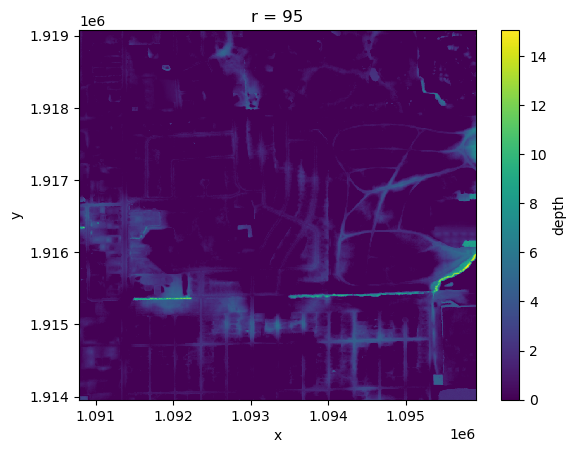

In [11]:
depth_ds.depth[95].plot()

In [5]:
with open(WEIGHTS, 'r') as weights_file:
    weights = list(json.load(weights_file).values())

In [6]:
AEPS = [1/return_period for return_period in RETURN_PERIODS]

for aep, return_period in zip(AEPS, RETURN_PERIODS):
    print(aep, return_period)
    depth_quantile_ds = fdu.depth_quantile(depth_ds.depth, aep, spatial_ref=depth_ds.spatial_ref, weights=weights)
    depth_quantile_ds.to_zarr(f"./data/depth_{return_period}.zarr", mode="w")

0.1 10


/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarni

0.02 50
0.01 100
0.002 500


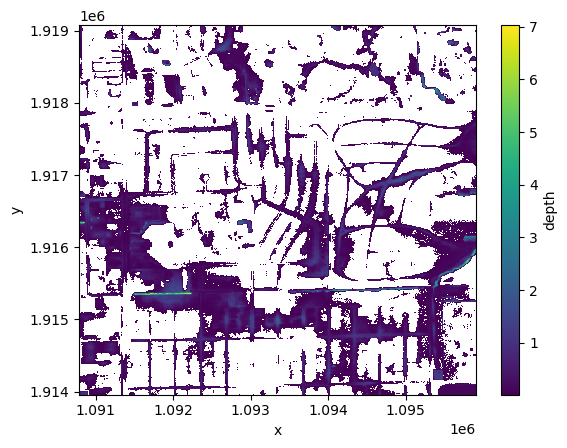

In [13]:
depth = xr.open_zarr("./data/depth_10.zarr").depth
depth.where(depth > 0.1).plot()

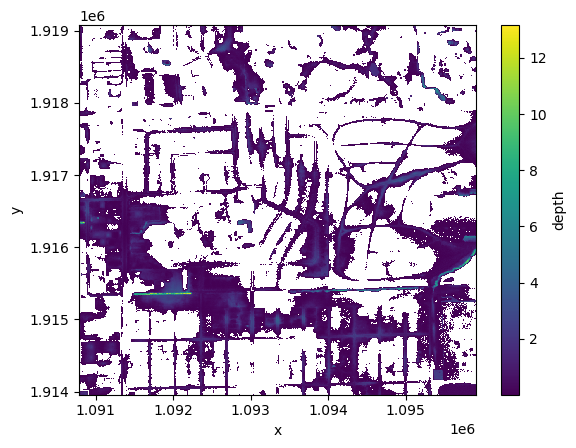

In [14]:
depth = xr.open_zarr("./data/depth_500.zarr").depth
depth.where(depth > 0.1).plot()

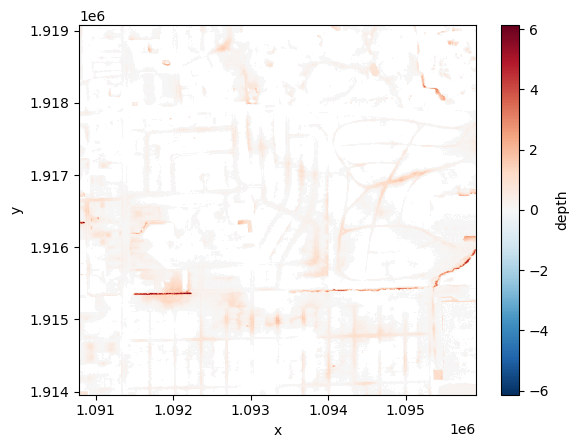

In [15]:
d10 = xr.open_zarr("./data/depth_10.zarr").depth
d500 = xr.open_zarr("./data/depth_500.zarr").depth
(d500 - d10).plot()

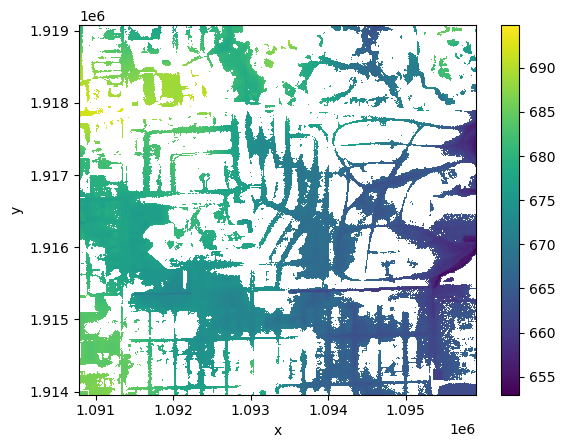

In [18]:
(d10 + wsel_ds.terrain).plot()